# Intro
We are Ram (123) and Or (315339960), and in this notebook, we are going to talk about data from 911 calls. We have looked far and wide for a dataset that has enough "meat" for a nice EDA, in a field that is interesting to us, and we believe we found it in this [Kaggle Dataset](https://www.kaggle.com/datasets/louisteitelbaum/911-recordings-first-6-seconds).

911 is an emergency telephone number for North America. Analysing emergency calls dataset can lead to solutions that could potentially help 911 operators.


This dataset contains a collection of usunsual or critical calls, including the full audio version of them, and only the first 6 seconds of each call. It also has a .csv table which includes features like title, state, number of casualities, was this call a false alarm etc.
We found the subject matter to be exteremly interesting, as well as countless ways to interact with the data itself - from speech to text, using text embeddings on these texts, to use those embeddings to cluster calls... the ways of interacting with the data felt endless.

# The Problem
911 gets around 657,000 calls, every single day in the US. This means thousands upon thousands of operators are needed, and they must perform flawlessly for hunderds of calls each and every day, with the extreme pressure that if they make a mistake - it could cost someone's life.
Right now the operator has to sift through all of those calls, and try to understand if every one of the callers is in real danger or not. Also, in many instances, the caller who is in danger might not want to reveal he is talking to 911, so he could be talking in code. The operator must differentiate between those who are in danger, to those who mixed up 911 with Domino's number.

We propose to make a model that can make their lives easier in several ways. 
For one, it can also listen in to the call with the operator, and try to make suggestions, to determine whether or not to send a police car to the call's location. Also, it can be used to determine whether or not the call was a false alarm. 
It can serve as an assistant to the operator, to help them reduce the amount of mistakes they make.

# Dataset Preface

This dataset is skewed towards irregular calls, that is used to train 911 operators. To use this data to correctly make predictions about random 911 calls could lead to bad results because of it. Therefore we also need more regular 911 call data.

## Setup
Let's keep the imports and setup here:

In [3]:
# Some installtions here:
!pip install geopandas

In [56]:
# Imports and setup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import YearLocator, DateFormatter
import itertools

sns.set_palette("pastel")
palette = itertools.cycle(sns.color_palette())



# EDA

First off, let's have a look at a sample of our data, so we can see the different columns that we have and examples of what they contain:

In [7]:
# load the dataset
df = pd.read_csv('911_metadata.csv')
print(f"total rows: {len(df)}")
df.sample(5)

total rows: 710


,id,event_id,link,title,date,state,deaths,potential_death,false_alarm,description,deaths_binary,break,filename
227,227,248,https://web.archive.org/web/20150417084845/htt...,Drowning CPR,6/12,Wisconsin,0.0,1.0,0.0,– In June 2012 a Yorkville (Wisc.) family was ...,0,21.0,911_first6sec/call_248_0.wav
476,476,515,https://web.archive.org/web/20150417085348/htt...,Roadside Murder,2/09,Colorado,2.0,1.0,0.0,In Feb. 2009 Amber Cremeens was forced off the...,1,5.0,911_first6sec/call_515_0.wav
402,402,427,https://web.archive.org/web/20150417085337/htt...,Drowning,3/13,California,1.0,1.0,0.0,– In March 2013 a woman accidentally drove int...,1,10.0,911_first6sec/call_427_0.wav
245,245,267,https://web.archive.org/web/20150417085340/htt...,Supermarket shootings,8/12,New Jersey,3.0,1.0,0.0,– In August 2012 an ex-soldier working at an O...,1,3.0,911_first6sec/call_267_0.wav
552,552,582,https://web.archive.org/web/20150417085351/htt...,Man chasing car,7/09,North Carolina,1.0,1.0,0.0,– In July 2009 a Burlington (NC) woman dialed ...,1,3.0,911_first6sec/call_582_0.wav


From this ~700 rows dataset, we have information about which state the call was made from, what month it happened in, was it a false alarm, how many people died as the result of the event, and a general title and description of what happened.
We also have the link to the original call audio file, which we will use later.

First off, let's clean this data:

In [20]:
# drop the duplicates
df_clean = df.drop_duplicates(subset=['id'])
print(f"total dataset count after deduplication: {len(df_clean)}") # 710 - no duplicates

# Transform binaries to booleans
df_clean['false_alarm'] = df['false_alarm'].replace({1: True, 0: False})
df_clean['potential_death'] = df['potential_death'].replace({1: True, 0: False})
df_clean['deaths_binary'] = df['deaths_binary'].replace({1: True, 0: False})

# Transform the date from string to datetime
def add_leading_zero(date_str):
    if date_str is None:
        return ''
    if len(date_str) < 5:
        return '0' + date_str
    else:
        return date_str

# Apply the function add_leading_zero to the 'date' column to make sure it starts with a 0
df_clean['date'] = df['date'].astype(str).apply(add_leading_zero)

# Assuming the 'date' column in your DataFrame is in datetime format
df_clean['date_dt'] = pd.to_datetime(df_clean['date'], format='%m/%y', errors='coerce')

total dataset count after deduplication: 710
0     2006-02-01
1     2005-03-01
2     2005-04-01
3     2005-01-01
4     2006-01-01
         ...    
705   2010-08-01
706   2010-08-01
707   2010-08-01
708   2010-08-01
709   2010-09-01
Name: date_dt, Length: 710, dtype: datetime64[ns]


As we can see, we have data about which state in the U.S. the call was made from. Let's plot this on a map of the US to get a picture of possible hot spots:

ValueError: 'pastel' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

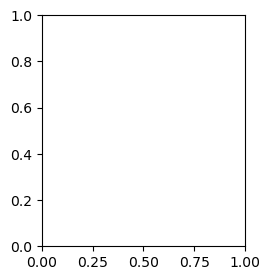

In [57]:
# Let's break it down by state
state_counts = df['state'].value_counts().reset_index()
state_counts.columns = ['state', 'count']
us_states = gpd.read_file('cb_2018_us_state_500k.shp')
us_states = us_states.merge(state_counts, left_on='NAME', right_on='state', how='left')
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
us_states.plot(column='count', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title(f"Number of Calls in each State (Alaska: {state_counts[state_counts['state'] == 'Alaska']['count'].values[0]})")
ax.set_xlim(-130,-65)
ax.set_ylim(20,50)
plt.show()


Florida, California, and Texas seem to lead, though it's no wonder considering the amount of people within these states, though in general the data seems pretty well distributes. Let's try to find out the state with the most calls per 1M people:

(20.0, 50.0)

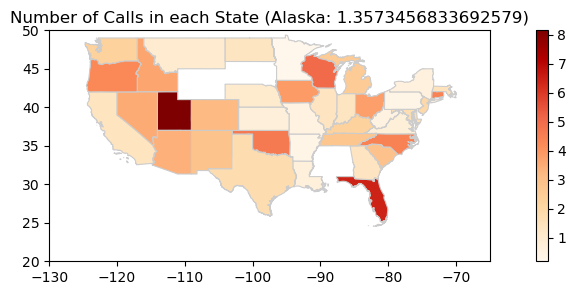

In [6]:
state_csv = pd.read_csv('https://gist.githubusercontent.com/bradoyler/0fd473541083cfa9ea6b5da57b08461c/raw/fa5f59ff1ce7ad9ff792e223b9ac05c564b7c0fe/us-state-populations.csv')
us_states_with_pop = us_states.merge(state_csv, left_on='STUSPS', right_on='code', how='left')
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
us_states_with_pop['calls_per_1M'] = (us_states_with_pop['count'] / us_states_with_pop['pop_2014']) * 1000000
us_states_with_pop.plot(column='calls_per_1M', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title(f"Number of Calls in each State (Alaska: {us_states_with_pop[us_states_with_pop['NAME'] == 'Alaska']['calls_per_1M'].values[0]})")
ax.set_xlim(-130,-65)
ax.set_ylim(20,50)

So if we needed to answer which state has the most troublesome average citizen, seems like Utah takes the cake with florida coming to a close second.

<Figure size 800x600 with 0 Axes>

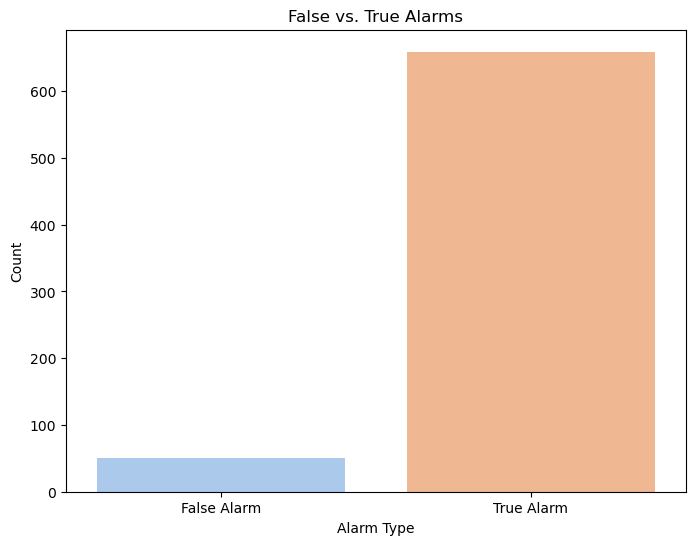

In [58]:
# Let's make a false alarm plot
# Count the number of false and true alarms
true_alarm_count = df_clean[df_clean['false_alarm'] == False]['id'].count()
false_alarm_count = df_clean[df_clean['false_alarm'] == True]['id'].count()

# Create a bar chart
plt.figure(figsize=(8, 6))

# Create a bar chart using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=['False Alarm', 'True Alarm'], y=[false_alarm_count, true_alarm_count])
plt.xlabel('Alarm Type')
plt.ylabel('Count')
plt.title('False vs. True Alarms')
plt.show()


Seems like the vast majority of the calls were not, in fact, false alarms. Which could pose a problem if we were to try and detect whether or not a call was a false alarm

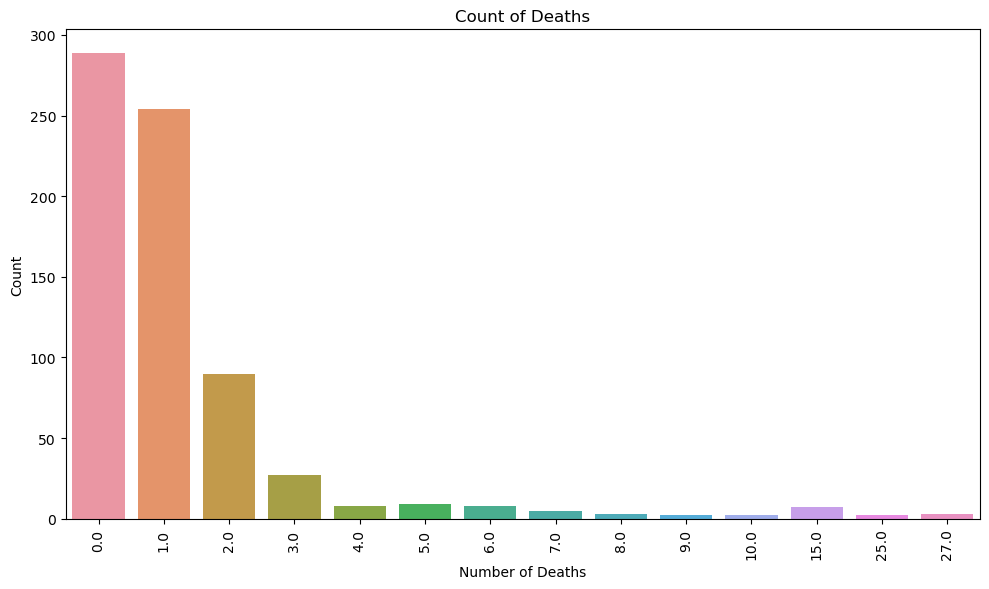

In [60]:
# Create a count plot of the 'deaths' column
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='deaths')
plt.xlabel('Number of Deaths')
plt.ylabel('Count')
plt.title('Count of Deaths')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


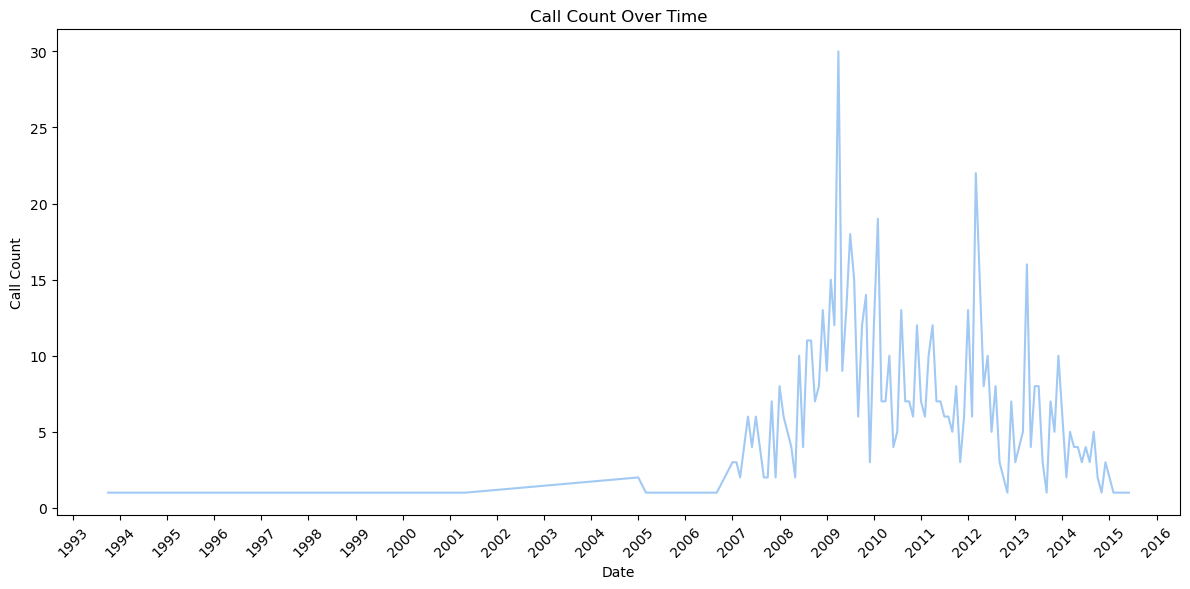

In [61]:
# Group the data by date and count the calls for each date
calls_by_date = df_clean.groupby('date_dt')['id'].count().reset_index()
years_locator = YearLocator(base=1)
years_format = DateFormatter('%Y')


# Create a line chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=calls_by_date, x='date_dt', y='id')

plt.gca().xaxis.set_major_locator(years_locator)
plt.gca().xaxis.set_major_formatter(years_format)

plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel('Call Count')
plt.title('Call Count Over Time')
plt.tight_layout()
plt.show()


potential_death  False  True 
deaths_binary                
False               87    202
True                13    407


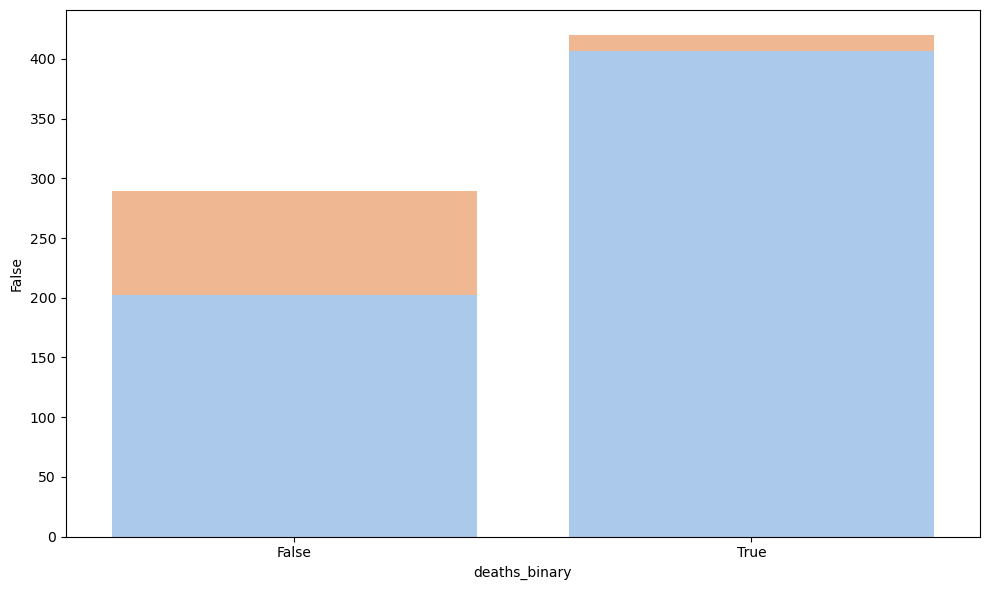

In [64]:
# Group the data by 'deaths_bool' and 'potential_deaths' columns and count the occurrences
grouped_data = df_clean.groupby(['deaths_binary', 'potential_death'])['id'].count().unstack()
print(grouped_data)
# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_data.reset_index(), x='deaths_binary', y=True, color=next(palette), label='Potential Death')
sns.barplot(data=grouped_data.reset_index(), x='deaths_binary', y=False, color=next(palette), label='Not Potential Death', bottom=grouped_data[True])

ax.set_xlabel('Potential Deaths')
ax.set_ylabel('Count')
ax.set_title('Cases with Potential Deaths and Outcomes')
ax.legend(title='Death Occurred', labels=['No', 'Yes'], loc='upper right')

plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.tight_layout()
plt.show()